# Programming 1 Final Assignment

## Does the urbanity of your township have an influence on once mental health?

A small data analysis on if urbanity of your howntown has any influence on your mental health? This small analysis dives into a few mental health aspects for juniors and adults and analyses if there are any correlations between the amount of adresses per km2 of a township and the scores people from this township give on their mental health survey. 

#### Sources

The data used come from different sources. Some are scraped from html webpages, saved as csv files or are geojson files. All sources are mentioned here and are openly accessible. 
- Adresses per km2 (webpage)
https://allecijfers.nl/gemeente/groningen/
- Determining urbanity (source webpage) https://www.cbs.nl/nl-nl/nieuws/2019/44/meeste-afval-per-inwoner-in-minst-stedelijke-gemeenten/stedelijkheid
- Mental health questionnaires (csv files) https://ggdgroningen.incijfers.nl/dashboard/dashboard/psychische-gezondheid/
- Township coordinates (middle points, webpage) https://www.coordinatenbepalen.nl/coordinates/620-delfzijl
- Township coordinates (borders, geojson) https://data.overheid.nl/dataset/5581-gemeentegrenzen-nederland--gegeneraliseerd-vlak-bestand

#### Librairies 

In [1]:
import pandas as pd
import numpy as np
import json
import folium
import requests
import re
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import panel as pn 
import seaborn as sns
import statsmodels.api as sm
import scipy

from bokeh.plotting import figure, show, ColumnDataSource, output_notebook
from bokeh.transform import dodge, transform
from bokeh.models.widgets import Panel, Tabs, Select
from bokeh.models import CustomJS, BasicTicker, ColorBar, ColumnDataSource,LinearColorMapper, PrintfTickFormatter
from bokeh.layouts import column, layout
from shapely.geometry import shape
from pandas import DataFrame
from re import search
from bokeh.palettes import Plasma256
from pyproj import Proj, transform

output_notebook()
pn.extension()

Loading BokehJS ...

### Data collection

This analysis focusses on urbanity of townships. Different kinds of information on townships is collected in this analysis and they all come from different sources. As they all come from different sources, they are all formatted differently. All types of formatting present are put in their own lists and are worked with throughout this file.

In [2]:
townships_lower = ['groningen', 'het-hogeland', 'delfzijl', 'midden-groningen',
          'oldambt', 'pekela', 'stadskanaal', 'veendam','westerkwartier']

In [3]:
townships_title = ['Groningen', 'Het Hogeland', 'Eemsdelta', 'Midden-Groningen',
          'Oldambt', 'Pekela', 'Stadskanaal', 'Veendam', 'Westerkwartier']

In [63]:
townships_title_d = ['Groningen', 'Het Hogeland', 'Delfzijl', 'Midden-Groningen',
          'Oldambt', 'Pekela', 'Stadskanaal', 'Veendam', 'Westerkwartier']

In [4]:
townships_variables = ['groningen', 'hogeland', 'delfzijl', 'middengroningen',
                       'oldambt', 'pekela', 'stadskanaal', 'veendam', 'westerkwartier']

In [5]:
townships_numbers = ['1003-groningen', '550674-het-hogeland-groningen', '620-delfzijl', '280017-midden-groningen',
          '55893-oldambt', '20407-pekela', '2220-stadskanaal', '2354-veendam','550844-westerkwartier-groningen']

#### Regional data

Regional data entails information on township names, their adresses per km2 and its calculated urbanity. Urbanity is determined by the addresses per km2 (source). For the sake of this analysis, the cutoff was made at 1000 adresses per km2 as this was mentioned to be 'rather urban'.

In [6]:
def regional_data():
    """
    Function that gets the regional data from an open source on the internet. The regional data is used to calculate
    urbanity from every township.
    
    returns:
    km       dataframe with township names, adresses km2 and their urbanity
    
    To test if the right information is put out, a unit test is done to check. 
    >>> regional_data()
               township  adresses km2 urbanity
    0         Groningen          3267    urban
    1      Het Hogeland           410    rural
    2          Delfzijl           678    rural
    3  Midden-Groningen           853    rural
    4           Oldambt           830    rural
    5            Pekela           531    rural
    6       Stadskanaal           836    rural
    7           Veendam          1002    urban
    8    Westerkwartier           475    rural
    """
    # create two empty lists; one for the number of adresses and one for the corresponding township names
    adresses = []
    township = []

    # loop through the array of township names; fill in the link where the numbers can be found and
    # do a request to gather data from the webpage
    for i in townships_lower:
        URL = f'https://allecijfers.nl/gemeente/{i}/'
        text = requests.get(URL).text
        
        # the numbers are found between two constant string; the start and end string are given and the number
        # between are saved in the adresses. The accompyning township names are saved in the township list
        start = text.find("De gemiddelde dichtheid van adressen is") + len("De gemiddelde dichtheid van adressen is")
        end = text.find("adressen per km")
        numbers = text[start:end]
        adresses.append(numbers)
        township.append(i)

    # lists to dataframe and rename the one township with the '-' character
    km = pd.DataFrame({'township':township, 'adresses km2':adresses})
    km['township'] = np.where((km['township'] == 'het-hogeland'),'Het Hogeland', km['township'])

    # set all township names to title convention to later on merge
    km['township'] = km['township'].str.title()    

    # drop 'dot' in thousends and set to int
    km['adresses km2'] = km['adresses km2'].str.replace('\.','').astype(int)

    # source: https://www.cbs.nl/nl-nl/nieuws/2019/44/meeste-afval-per-inwoner-in-minst-stedelijke-gemeenten/stedelijkheid
    # set urbanity column and fill with according rural or urban disctription
    km['urbanity'] = np.where((km['adresses km2'] <= 1000), 'rural', 'urban')
    
    return km

In [7]:
# set dataframe name to function call
km = regional_data()        
# the km dataframe shows the township name, its adressed per km and its calculated urbanity
km

<ipython-input-6-d866dad4fc6a>:48: FutureWarning: The default value of regex will change from True to False in a future version.
  km['adresses km2'] = km['adresses km2'].str.replace('\.','').astype(int)


,township,adresses km2,urbanity
0,Groningen,3267,urban
1,Het Hogeland,410,rural
2,Delfzijl,678,rural
3,Midden-Groningen,853,rural
4,Oldambt,830,rural
5,Pekela,531,rural
6,Stadskanaal,836,rural
7,Veendam,1002,urban
8,Westerkwartier,475,rural


### Mental data

Mental data entails information on the people's mental health. A study done by the GGD groningen has provided several questions which lead to percentual answers. These questions entail (moderetely) risk on psychosocial problems and hapiness, divided in juniors and adults. The mental data is saved per township and lateron combined.

In [8]:
def mental_data():
    """
    Function that gets the mental data from a given file. The file is opened and handled to get to the proper workable
    format.
    
    returns:
    {township name}       dataframes for every township, containing the numerical data on mental health
    """
    
    # create emtpy list vor the data
    mental_data = []

    # open the files and append to the list
    for town in townships_title:
        town = pd.read_csv(f'data/Psychische gezondheid - {town}.csv', sep=';')
        mental_data.append(town)
    
    # assign the township variables to the data in the list
    # could also be done in a dict possibly
    groningen = mental_data[0]
    hogeland = mental_data[1]
    delfzijl = mental_data[2]
    middengroningen = mental_data[3]
    oldambt = mental_data[4]
    pekela = mental_data[5]
    stadskanaal = mental_data[6]
    veendam = mental_data[7]
    westerkwartier = mental_data[8]

    # the original data contains a comparison between a township and the township 'Het Hogeland'. The 'Het Hogeland'
    # needs to be dropped in every dataframe under the column 'regio / dimensie'
    to_drop = 'Het Hogeland'
    to_replace = 'regio / dimensie'
    
    groningen  = hogeland.drop(hogeland[hogeland[to_replace] == to_drop].index)
    hogeland = hogeland.drop(hogeland[hogeland[to_replace] == 'Groningen'].index) 
    delfzijl = delfzijl.drop(delfzijl[delfzijl[to_replace] == to_drop].index) 
    middengroningen = middengroningen.drop(middengroningen[middengroningen[to_replace] == to_drop].index) 
    oldambt = oldambt.drop(oldambt[oldambt[to_replace] == to_drop].index) 
    pekela = pekela.drop(pekela[pekela[to_replace] == to_drop].index) 
    stadskanaal = stadskanaal.drop(stadskanaal[stadskanaal[to_replace] == to_drop].index) 
    veendam = veendam.drop(veendam[veendam[to_replace] == to_drop].index) 
    westerkwartier = westerkwartier.drop(westerkwartier[westerkwartier[to_replace] == to_drop].index) 
        
    
    return(groningen, hogeland, delfzijl, middengroningen, oldambt, pekela, stadskanaal, veendam, westerkwartier)

In [9]:
# assign dataframe to list indeces
groningen = mental_data()[0] 
hogeland = mental_data()[1]
delfzijl = mental_data()[2]
middengroningen = mental_data()[3]
oldambt = mental_data()[4]
pekela = mental_data()[5]
stadskanaal = mental_data()[6]
veendam = mental_data()[7]
westerkwartier = mental_data()[8]

In [10]:
def mental_data_edit():
    """
    Function that summarizes the townships dataframes and transforms to the proper dataframe
    
    returns:
    mental_edit       dataframe with township names, indicator, percentage and generation
    """
        
    townships_mental = [groningen, hogeland, delfzijl, middengroningen, oldambt, 
                        pekela, stadskanaal, veendam, westerkwartier]

    # combine all townships dataframes
    mental_edit = pd.concat(townships_mental).reset_index()
    
    # drop unnesecary/double columns
    mental_edit = mental_edit.drop(['index', 'Dashboard', 'Tegel','Bron','Omschrijving','Eenheid'], axis=1)
    
    # rename for proper syntax
    mental_edit = mental_edit.rename(columns={'Indicator': 'indicator', 'Periode': 'year', 
                                    'regio / dimensie': 'township', 'Waarde':'percentage'})
    
    # add generation column 
    mental_edit['generation'] = np.where((mental_edit['indicator'].str.contains('jongeren')), 'junior', 'adult')
    
    # township eemsdelta was founded in 2021; the older dataset still calls it delfzijl 
    mental_edit['township'] = mental_edit['township'].replace('Eemsdelta', 'Delfzijl')
    
    # translate column names from dutch to english
    mental_edit['indicator'] = mental_edit['indicator'].replace(
    {'Percentage jongeren dat zich meestal (zeer) gelukkig voelt (score 4 of 5)': 'Mostly (very) happy',
    'Percentage volwassenen dat zich altijd of meestal gelukkig voelt': 'Mostly (very) happy',
    'Percentage jongeren dat een matig verhoogd of verhoogd risico heeft op psychosociale problemen': 
     'Moderately increased or increased risk of psychosocial problems',
    'Percentage volwassenen met een matig risico op een angst- of depressiestoornis': 
     'Moderately increased risk of psychosocial problems',
    'Percentage volwassenen met een hoog risico op een angst- of depressiestoornis': 
     'Increased risk of psychosocial problems'})
    
    return mental_edit

In [11]:
mental_edit = mental_data_edit()
mental_edit.head()

,indicator,year,township,percentage,generation
0,Mostly (very) happy,2019,Groningen,82,junior
1,Mostly (very) happy,2016,Groningen,58,adult
2,Moderately increased or increased risk of psyc...,2019,Groningen,15,junior
3,Moderately increased risk of psychosocial prob...,2016,Groningen,33,adult
4,Increased risk of psychosocial problems,2016,Groningen,"5,5",adult


In [12]:
def final_dataframe():
    """
    function that creates the final dataframe to be used lateron the file
    
    returns
    data     dataframe in the final format including township, urbanity, km2 and all the indicators
    
    """
    
    # merge dataframe containing km information and mental state information
    data = pd.merge(mental_edit, km, on='township')
    # set all the proper data types
    data = data.convert_dtypes()

    # create junior dataframe for suffixes
    junior = data[data['generation'] == 'junior']
    
    # reshape dataframe 
    junior_scores = junior.reset_index().groupby(['index', 'township', 'indicator'])['percentage'].aggregate('first').unstack()
    junior_scores = junior_scores.groupby(['township']).first().reset_index()
    junior_scores = pd.merge(junior_scores, km, on='township')
    junior_scores = junior_scores.set_index(['township', 'urbanity', 'adresses km2']).add_suffix(' (junior)')
    junior_scores = junior_scores.reset_index()

    # create adult dataframe for suffixes
    adult = data[data['generation'] == 'adult']
    
    # reshape dataframe 
    adult_scores = adult.reset_index().groupby(['index', 'township', 'indicator'])['percentage'].aggregate('first').unstack()
    adult_scores = adult_scores.groupby(['township']).first().reset_index()
    adult_scores = pd.merge(adult_scores, km, on='township')
    adult_scores = adult_scores.set_index(['township', 'urbanity', 'adresses km2']).add_suffix(' (adult)')
    adult_scores = adult_scores.reset_index()

    # merge newly created dataframes
    data = pd.merge(junior_scores, adult_scores, on=['township','urbanity', 'adresses km2'])
    
    # set all data types to integers
    data['Increased risk of psychosocial problems (adult)'] = [x.replace(',', '.') for x in data['Increased risk of psychosocial problems (adult)']]
    data['Increased risk of psychosocial problems (adult)'] = data['Increased risk of psychosocial problems (adult)'].astype('float')
    data['Moderately increased or increased risk of psychosocial problems (junior)'] = data['Moderately increased or increased risk of psychosocial problems (junior)'].astype('int')
    data['Mostly (very) happy (junior)'] = data['Mostly (very) happy (junior)'].astype('int')
    data['Moderately increased risk of psychosocial problems (adult)'] = data['Moderately increased risk of psychosocial problems (adult)'].astype('int')
    data['Mostly (very) happy (adult)'] = data['Mostly (very) happy (junior)'].astype('int')

    # create averaged columns
    data['Increased risk of pshychosocial problems (total average)'] = ((data['Moderately increased or increased risk of psychosocial problems (junior)'] + ((data['Increased risk of psychosocial problems (adult)'] + data['Moderately increased risk of psychosocial problems (adult)']) /2))/2).round(1)
    data['Mostly (very) happy (total average)'] = ((data['Mostly (very) happy (adult)'] + data['Mostly (very) happy (junior)'])/2)
        
    return data

In [13]:
def reverseScoring(df, high, cols):
    """
    function that reverses the scores
    
    parameters
    df    dataframw with the needed to be reversed columns
    high  highest score possible
    cols  cols to be reversed
    
    returns
    df    dataframe with reversed columns
    """
    df[cols] = high - df[cols]
    return df

def reversed_columns():
    """
    function that reverses the columns and puts in new dataframe
    
    Returns
    data    Dataframe with reversed columns
    """
    negative_based = ['Moderately increased or increased risk of psychosocial problems (junior)',
                      'Increased risk of psychosocial problems (adult)',
                      'Moderately increased risk of psychosocial problems (adult)',
                      'Increased risk of pshychosocial problems (total average)']

    for i in negative_based:
        reverseScoring(data, 100, i)
    return data

In [14]:
data = mental_data_edit()

In [15]:
data = final_dataframe()

In [16]:
data = reversed_columns()

In [17]:
# The final dataframe contains all the information needed; township names, urbanity and its 
# adresses km2 and all the indicators.
data

,township,urbanity,adresses km2,Moderately increased or increased risk of psychosocial problems (junior),Mostly (very) happy (junior),Increased risk of psychosocial problems (adult),Moderately increased risk of psychosocial problems (adult),Mostly (very) happy (adult),Increased risk of pshychosocial problems (total average),Mostly (very) happy (total average)
0,Delfzijl,rural,678,78,74,94.1,72,74,80.5,74.0
1,Groningen,urban,3267,85,82,94.5,67,82,82.9,82.0
2,Het Hogeland,rural,410,78,81,95.9,72,81,81.0,81.0
3,Midden-Groningen,rural,853,78,79,93.9,72,79,80.5,79.0
4,Oldambt,rural,830,79,80,94.2,71,80,80.8,80.0
5,Pekela,rural,531,84,87,93.3,66,87,81.8,87.0
6,Stadskanaal,rural,836,75,78,90.3,74,78,78.6,78.0
7,Veendam,urban,1002,84,79,93.1,69,79,82.5,79.0
8,Westerkwartier,rural,475,80,79,96.7,73,79,82.4,79.0


In [18]:
def rural_urban_df():
    """
    function that transforms dataframe to all numeric data and splits dataframe into rural and urban
    
    returns
    urban               Dataframe with only urban data (numeric)
    rural               Dataframe with only rural data (numeric)
    mapping_dataframe   Dataframe with only numeric data for columns

    """
    
    # create mapping dict for all the townships
    mapping = {'Delfzijl': 1, 'Groningen': 2, 'Het Hogeland': 3, 'Midden-Groningen': 4, 
               'Oldambt':5, 'Pekela':6, 'Stadskanaal':7, 'Veendam':8, 'Westerkwartier':9}

    # replace townships with their mapping
    mapping_dataframe = data.replace({'township': mapping})
    
    # replace urbanity column with numeric data
    mapping_dataframe['urbanity'] = mapping_dataframe['urbanity'].replace({'urban':1, 'rural':0})
    
    # sort from small to large km2
    mapping_dataframe = mapping_dataframe.sort_values(by=['adresses km2'])

    # create two seperate dataframes for urban and rural
    urban = mapping_dataframe[mapping_dataframe['urbanity'] == 1].sort_values(by=['adresses km2'])
    rural = mapping_dataframe[mapping_dataframe['urbanity'] == 0].sort_values(by=['adresses km2'])
    
    return(urban, rural, mapping_dataframe)

In [19]:
urban = rural_urban_df()[0]
rural = rural_urban_df()[1]
mapping_dataframe = rural_urban_df()[2]

In [20]:
urban

,township,urbanity,adresses km2,Moderately increased or increased risk of psychosocial problems (junior),Mostly (very) happy (junior),Increased risk of psychosocial problems (adult),Moderately increased risk of psychosocial problems (adult),Mostly (very) happy (adult),Increased risk of pshychosocial problems (total average),Mostly (very) happy (total average)
7,8,1,1002,84,79,93.1,69,79,82.5,79.0
1,2,1,3267,85,82,94.5,67,82,82.9,82.0


In [21]:
rural

,township,urbanity,adresses km2,Moderately increased or increased risk of psychosocial problems (junior),Mostly (very) happy (junior),Increased risk of psychosocial problems (adult),Moderately increased risk of psychosocial problems (adult),Mostly (very) happy (adult),Increased risk of pshychosocial problems (total average),Mostly (very) happy (total average)
2,3,0,410,78,81,95.9,72,81,81.0,81.0
8,9,0,475,80,79,96.7,73,79,82.4,79.0
5,6,0,531,84,87,93.3,66,87,81.8,87.0
0,1,0,678,78,74,94.1,72,74,80.5,74.0
4,5,0,830,79,80,94.2,71,80,80.8,80.0
6,7,0,836,75,78,90.3,74,78,78.6,78.0
3,4,0,853,78,79,93.9,72,79,80.5,79.0


In [64]:
def json_coordinates_df():
    """
    Function that reads geojson file to a dataframe with needed coordinates.
    
    Returns
    township_coordinates_df   A dataframe with township names and their border coordinates
    json_data              A json file with township names and their border coordinates
    """
    # open geojson file, source can be found at top of the page
    with open('data/0943f565-f83a-48d3-b848-8b1778e83517.json') as imported_json:
        json_data = json.load(imported_json)

    # create a dataframe and add all township names and their coordinates to it
    township_coordinates_df = pd.DataFrame()
    for feature in json_data['features']:
        township_coordinates_df = township_coordinates_df.append(
            {'township': feature['properties']['GEMEENTENAAM'], 
            'coordinates': feature['geometry']['coordinates'][0]}, 
            ignore_index=True)

    # As the geojson file contains all townships of the netherlands, and only townships of groningen are needed
    # in this analysis, they are run against the townships list created in the beginnning of this file
    # to drop the once we do not need.
    township_coordinates_df = township_coordinates_df.loc[township_coordinates_df['township'].isin(townships_title_d)].reset_index()
    township_coordinates_df = township_coordinates_df.drop(['index'], axis=1)
    
    return (township_coordinates_df, json_data)

In [65]:
# set variable to function call
township_coordinates_df = json_coordinates_df()[0]
json_data = json_coordinates_df()[1]

In [71]:
def json_coordinates():
    """
    Function that reads geojson file to a json file with needed coordinates.
    
    Returns
    township_coordinates   A json with township names and their border coordinates
    """
    # filter json file to only needed townships
    filtered_json = []
    
    # loop through json file to drop all not needed township (checked against township lists made in the beginning)
    for feature in json_data['features']:
        township_name = feature['properties']['GEMEENTENAAM']   
        for township in townships_title_d:
            if township in township_name:
                filtered_json.append(feature)

    # overwrite json file 
    json_data['features'] = filtered_json

    # write new json file with only needed township coordinates
    with open('data/township-coordinates.json', 'w') as f:
        json.dump(json_data, f)

    # open newly written json file
    with open('data/township-coordinates.json') as json_coordinates:
        township_coordinates = json.load(json_coordinates)
    
    return township_coordinates

In [72]:
# set variable to function call. This variable ends with 28992, as the coordinates used in this json file
# are set in the 28992 format. This ended up being the wrong format (used only in the Netherlands) and thus
# for clearity lateron, this was added to the variable name.
township_coordinates_28992 = json_coordinates()

In [74]:
# this import is done here as there are two types of transform imports done in this document. If not mentioned
# in the same block; python did not like it.
from pyproj import Proj, transform
def transform_coordinates():
    """
    Function to transform coordinates. The original geojson file contained coordinates in the espg 28992 format,
    which is a format only used in the Netherlands. Folium (used to create a map later-on) only accepts espg 4326
    coordinate formatting and thus this function is needed to work with the folium map.
    
    Returns
    township_coordinates    A json file with the township border coordinates
    """
    
    # loop through township coordinates in the original formatting and get the coordinates
    for i in township_coordinates_28992['features']:
        coor = i['geometry']['coordinates'][0]
        # create list for new coordinates
        new_coor = []
        # using the pyproj Proj library to tranform epsg 28992 to epsg 4326
        # set the coordinates input 
        inProj = Proj(init='epsg:28992')
        # set the coordinates output
        outProj = Proj(init='epsg:4326')
        # loop through coordinates and transform
        for co in coor:
            x1,y1 = co[0], co[1]
            x2,y2 = transform(inProj,outProj,x1,y1)
            # append new coordinates to list
            new_coor.append([x2,y2])
        # overwrite coordinates in original json file
        i['geometry']['coordinates'] = [new_coor]
        
    return township_coordinates_28992

In [75]:
# set new variable to overwritten file; it now contains the coordinates in 4326 formatting
township_coordinates_4326 = transform_coordinates()

C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change,

<ipython-input-74-124698e12c85>:27: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2,y2 = transform(inProj,outProj,x1,y1)
C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwar

C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change,

<ipython-input-74-124698e12c85>:27: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2,y2 = transform(inProj,outProj,x1,y1)
C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Henrike\anaconda3\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwar

In [77]:
def latlon_df_part_1():
    """
    Function that creates three lists of township names, latitude and longitude of the middle points of the 
    needed townships. These are needed to show if a township is urban or rural.
    
    Returns
    township    List containing the township name
    latitude    List containing the latitude of middle point for township
    longitude   List containing the longitude of middle point for township
    """
    # create three empty lists; one for latitude, one for longitude and one for the accompying townships
    township = []
    latitude = []
    longitude = []

    # loop through the array of township names; fill in the link where the numbers can be found and
    # do a request to gather data from the webpage
    for number in townships_numbers:
        URL = f'https://www.coordinatenbepalen.nl/coordinates/{number}/'
        text = requests.get(URL).text

        # every webpage contains the same formatting for where the longitude and latitude can be found
        # these are entered as a point to find the correct numbers and after that added to the needed list
        start = text.find("Breedtegraad (latitude): ")
        end = text.find("<br>Lengtegraad (longitude):")
        numbers = text[start:end]
        latitude.append(numbers)
        township.append(number)
        
    # loop through the array of township names; fill in the link where the numbers can be found and
    # do a request to gather data from the webpage
    for number in townships_numbers:
        URL = f'https://www.coordinatenbepalen.nl/coordinates/{number}/'
        text = requests.get(URL).text
        
        # every webpage contains the same formatting for where the longitude and latitude can be found
        # these are entered as a point to find the correct numbers and after that added to the needed list
        start = text.find("Lengtegraad (longitude):")
        end = text.find('</h3>\n\n    <div class="well bg-orange">')
        numbers = text[start:end]
        longitude.append(numbers)

    # create new list for new_towns; the formatting of townships is different on the source page and thus needs
    # reforming to match up
    new_towns = []
    for i in township:
        town = i.split("-")
        new_towns.append(town[1:])

    # create a new list for latitude and longitude as the scraped information contains information which is not needed
    new_latitude = []
    for i in latitude:
        lat = i.split(': ')
        new_latitude.append(lat[1])

    new_longitude = []
    for i in longitude:
        long = i.split(': ')
        new_longitude.append(long[1])

    for idx, i in enumerate(new_towns):
        new_town = '-'.join(i)
        new_towns[idx] = new_town

    for i in new_towns:
        fullstring = i
        for idx, i in enumerate(townships_lower):
            substring = i
            if search(substring, fullstring):
                new_towns[idx] = i.title()
                
    return(new_towns, new_latitude, new_longitude)

In [78]:
# set variables to function call
new_towns = latlon_df_part_1()[0]
new_latitude = latlon_df_part_1()[1]
new_longitude = latlon_df_part_1()[2]

In [79]:
def latlon_df_part_2():
    """
    Function that creates the actual dataframe from the lists created in part 1 of this function. This dataframe
    contains the lat-long information for all townships and their addresses km2.
    
    Return
    latlon    Dataframe with lat-long information 
    
    Runs a unit test to check if it scrapes the correct information from the webpage.
    
    >>> latlon_df_part_2()
               township     latitude         longitude  adresses km2 urbanity
    0         Groningen   53.2193835         6.5665018          3267    urban
    1      Het Hogeland  53.41292275  6.50572993763598           410    rural
    2          Delfzijl   53.3310272         6.9244598           678    rural
    3  Midden-Groningen   53.1846736  6.77957351472961           853    rural
    4           Oldambt   53.2036908           7.05297           830    rural
    5            Pekela   53.0852407         6.9778815           531    rural
    6       Stadskanaal   52.9919853         6.9462217           836    rural
    7           Veendam   53.1062782         6.8750998          1002    urban
    8    Westerkwartier  53.21425645  6.34598133794401           475    rural
    """
    towns_latlon = [new_towns, new_latitude, new_longitude]

    towns_latlon_df = DataFrame (towns_latlon).transpose()
    towns_latlon_df.columns = ['township', 'latitude', 'longitude']
    towns_latlon_df ['township'] = np.where((towns_latlon_df ['township'] == 'Het-Hogeland'),'Het Hogeland', towns_latlon_df ['township'])

    latlon = pd.merge(towns_latlon_df, km, on='township')
    return latlon

In [80]:
# set variable to function call
latlon = latlon_df_part_2()
latlon

,township,latitude,longitude,adresses km2,urbanity
0,Groningen,53.2193835,6.5665018,3267,urban
1,Het Hogeland,53.41292275,6.50572993763598,410,rural
2,Delfzijl,53.3310272,6.9244598,678,rural
3,Midden-Groningen,53.1846736,6.77957351472961,853,rural
4,Oldambt,53.2036908,7.05297,830,rural
5,Pekela,53.0852407,6.9778815,531,rural
6,Stadskanaal,52.9919853,6.9462217,836,rural
7,Veendam,53.1062782,6.8750998,1002,urban
8,Westerkwartier,53.21425645,6.34598133794401,475,rural


### data analysis

After all data is collected and put into proper formatting and/or dataframes. Analysis can begin.

In [81]:
# check if there are any missing values
# there are no missing values
def check_null():
    """ 
    check if there are any missing values
    """
    return(data.isnull())

In [33]:
check_null()
# as can be seen, there is no missing data.

,township,urbanity,adresses km2,Moderately increased or increased risk of psychosocial problems (junior),Mostly (very) happy (junior),Increased risk of psychosocial problems (adult),Moderately increased risk of psychosocial problems (adult),Mostly (very) happy (adult),Increased risk of pshychosocial problems (total average),Mostly (very) happy (total average)
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False


In [82]:
# inspect data and information in general
# there are no abnormal things spotted here
data.describe().round(1)

,adresses km2,Moderately increased or increased risk of psychosocial problems (junior),Mostly (very) happy (junior),Increased risk of psychosocial problems (adult),Moderately increased risk of psychosocial problems (adult),Mostly (very) happy (adult),Increased risk of pshychosocial problems (total average),Mostly (very) happy (total average)
count,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
mean,986.9,80.1,79.9,94.0,70.7,79.9,81.2,79.9
std,877.7,3.4,3.5,1.8,2.7,3.5,1.3,3.5
min,410.0,75.0,74.0,90.3,66.0,74.0,78.6,74.0
25%,531.0,78.0,79.0,93.3,69.0,79.0,80.5,79.0
50%,830.0,79.0,79.0,94.1,72.0,79.0,81.0,79.0
75%,853.0,84.0,81.0,94.5,72.0,81.0,82.4,81.0
max,3267.0,85.0,87.0,96.7,74.0,87.0,82.9,87.0


#### plots

In [83]:
def bar_mood():
    """
    Function that plots a bar graph, grouped on township. Shows all the townships and their scores for the accompying
    indicator. These are all given per junior scores, adult scores and averaged.
    """
    # figure labels
    labels = data['township']
    source = ColumnDataSource(data)

    # adults
    # create figure
    p1 = figure(x_range=labels, title="Mental scores for adults per township", plot_width=900)

    p1.vbar(x=dodge('township', -0.2, range=p1.x_range), top='Increased risk of psychosocial problems (adult)', width=0.2, source=source, color="hotpink", legend_label='Increased risk of psychosocial problems')
    p1.vbar(x=dodge('township',  0.0,  range=p1.x_range), top='Moderately increased risk of psychosocial problems (adult)', width=0.2, source=source, color="orange", legend_label='Moderately increased risk of psychosocial problems')
    p1.vbar(x=dodge('township',  0.2,  range=p1.x_range), top='Mostly (very) happy (adult)', width=0.2, source=source, color="yellow", legend_label='Mostly (very) happy')

    p1.legend.location = "bottom_left"
    p1.xaxis.major_label_orientation = "vertical"
    p1.legend.click_policy= 'hide'
    tab1 = Panel(child=p1, title='Adults')

    # juniors
    # create figure
    p2 = figure(x_range=labels, title="Mental scores for juniors per township", plot_width=900)

    p2.vbar(x=dodge('township', -0.1, range=p2.x_range), top='Moderately increased or increased risk of psychosocial problems (junior)', width=0.2, source=source, color="lightblue", legend_label='Moderately increased or increased risk of psychosocial problems')
    p2.vbar(x=dodge('township',  0.1,  range=p2.x_range), top='Mostly (very) happy (junior)', width=0.2, source=source, color="yellow", legend_label='Mostly (very) happy')

    p2.legend.location = "bottom_left"
    p2.xaxis.major_label_orientation = "vertical"
    p2.legend.click_policy= 'hide'
    tab2 = Panel(child=p2, title='Junior')
    
    # average
    # create figure
    p3 = figure(x_range=labels, title="Mental scores averaged per township", plot_width=900)

    p3.vbar(x=dodge('township', -0.1, range=p2.x_range), top='Increased risk of pshychosocial problems (total average)', width=0.2, source=source, color="hotpink", legend_label='Increased risk of pshychosocial problems (total average)')
    p3.vbar(x=dodge('township',  0.1,  range=p2.x_range), top='Mostly (very) happy (total average)', width=0.2, source=source, color="yellow", legend_label='Mostly (very) happy (total average)')

    p3.legend.location = "bottom_left"
    p3.xaxis.major_label_orientation = "vertical"
    p3.legend.click_policy= 'hide'
    tab3 = Panel(child=p3, title='Average')

    tabs = Tabs(tabs=[tab1, tab2, tab3])
    show(tabs)

In [84]:
bar_mood()
# The bar graph grouped on township shows that for adults
# - Increased risk is alway the highest, which might have to do with age
# - Moderetely increased risk is always lowest, which might have to do with that they have surpassed the stage
# of moderetly, and are already in the increased risk....
# - All indicators are on average quite the same

# The bar graph grouped on thownship shows that for junior
# - Hapiness is almost always better than the (moderately) increaesd risk of pshychosocial problems 
# except for Delfzijl, Groningen and Veendam. Which is interesting as Groningen and Veendam
# qualified as urban townships (which can be seen in the dataframe 'data')

In [37]:
def bar_township():
    """
    Function that creates a barplot grouped by urbanity, which gives a better overview if any indicators are
    dependend on urbanity and if so, which indicator(s).
    """
    
    # Group by urbanity; and drop adresses km2 which is not needed for this plot. 
    # Means are calculated as it is grouped by urbanity, this is needed.
    bar = data.drop('adresses km2', axis=1).groupby(['urbanity']).mean().round(1).T.reset_index()

    # indicators to a list to get labels
    moods = bar['index'].unique().tolist()

    # set data source
    source = ColumnDataSource(bar)
    
    # create figure
    p = figure(x_range=moods, y_range=(0, 100), title='Average mood scores on urbanity', plot_height=800)

    # add rural data to figure
    p.vbar(x=dodge('index', -0.2, range=p.x_range), top='rural', width=0.3, source=source, color='hotpink', legend_label='Rural')
    
    # add urban data to figure
    p.vbar(x=dodge('index',  0.1,  range=p.x_range), top='urban', width=0.3, source=source, color='orange', legend_label='Urban')

    # set axis and label settings
    p.legend.location = "bottom_left"
    p.xaxis.major_label_orientation = "vertical"
    p.legend.click_policy= 'hide'
    p.legend.orientation = "horizontal"

    show(p)

In [38]:
barplot_averaged = bar_township()
barplot_averaged
# The bar graph grouped on urbanity/indicators can already be viewed as more interesting and applicable for this
# research question. You can already see that the differences in scores are realy small, not even a 5% differencce in
# rural vs urban. Which already kind off indicates that urbanity might have nothing to do with influencing mental health
# The one to mention is moderately or increased risk of psychosocial problems for juniors as this one clearly has the
# highest difference.

In [39]:
def scatter_moods():
    """
    Function that creates a scatterplot. The scatterplot should give a good indication on if and if yes, how indicators
    and urbanity might be correlated. 
    
    All indicators are plotted in the scatterplots against the adresses per km2 on the x-axis which are
    in ascending order.
    """
    # Create a scatter plot ploting the relation between being mental and township with different colors for urbanity
    tabs = pn.Tabs()
    index = 0

    # loop through columns and add to list of column names; skip first 3 columns
    for key, value in rural.iteritems():
        if index > 2:
            # create figure for every loop; voor every indicator (which are the column names, 'keys')
            p = figure(x_axis_label='Urbanity (adresses per km2)', y_axis_label=key, title= f'{key} vs urbanity')

            # plot scatter plot
            p.scatter(rural['adresses km2'], rural[key], size=15, color="orange", alpha=0.8, legend_label = 'Rural')
            p.scatter(urban['adresses km2'], urban[key], size=15, color="hotpink", alpha=0.8, legend_label = 'Urban')

            tabs.append((key, p))
        index = index + 1
    return tabs

In [40]:
scatterplot_moods = scatter_moods()
scatterplot_moods
# The scatterplots are arranged on indicator vs adresses per km (which is ascending horizontally)
# overall the scatterplots indicate that there is no correlation between any of the indicators and the adresses per km.
# There are a couple of outliers, which are for the urban urbanity. But as these shoot out of range, 
# they might not be representative of what the goal is. Thus, this scatterplot does not show any 
# correlations between any of the indicators and the adresses per km2.

Tabs
    [0] Bokeh(Figure, name='Moderately increased o...)
    [1] Bokeh(Figure, name='Mostly (very) h...)
    [2] Bokeh(Figure, name='Increased risk o...)
    [3] Bokeh(Figure, name='Moderately increased r...)
    [4] Bokeh(Figure, name='Mostly (very) h...)
    [5] Bokeh(Figure, name='Increased risk o...)
    [6] Bokeh(Figure, name='Mostly (very) h...)

In [41]:
def correlations_df():
    """
    Function that calculates the correlation between the needed columns. Pearson's R, measures
    linear correlation. This approach is used to see if any correlation can be found between the columns given.
    
    return
    correlations_df   Dataframe with correlations and accompying columns
    y_range           Column ranges
    x_range           Index ranges
    """
    # get the correlation numbers
    correlations = data.corr().abs()
    
    # get the ranges for later on heatmap
    y_range = (list(reversed(correlations.columns)))
    x_range = (list(correlations.index))

    # set to dataframe and reframe
    correlations_df = pd.DataFrame(correlations.stack(), columns=['r'])
    correlations_df = correlations_df.sort_values(by=['r'], ascending=False).reset_index()
    
    # return dataframe and ranges
    return (correlations_df, y_range, x_range)

In [87]:
# set variables/dataframes to function call
correlations = correlations_df()[0]
y_range = correlations_df()[1]
x_range = correlations_df()[2]

pd.options.display.max_colwidth = 100

# shown from 34th row up till 61st because up to 34th shows the same columns which have an r of 1.00, show the
# columns that originate from each other (average column based on the other columns) which is also
# logical they have a higher correlation or do not show the needed columns (adresses km2) as we focus on that especially
# in this analysis.
correlations.loc[34:61]

# the highest correlation calculated is for ´moderately increased or increased risk of pshycosocial problems )junior´
# and (moderately) increaed risk of psychosocial problems (adult). The highest correlations are around 0,4-0,5 which
# indicates a moderate correlation, even though this could not be seen in the scatterplot.
# the other correlations hang around 0,1-0,2 which does not show any or maybe a weak correlation. 

,level_0,level_1,r
34,adresses km2,Moderately increased or increased risk of psychosocial problems (junior),0.520563
35,Moderately increased or increased risk of psychosocial problems (junior),adresses km2,0.520563
36,adresses km2,Moderately increased risk of psychosocial problems (adult),0.487148
37,Moderately increased risk of psychosocial problems (adult),adresses km2,0.487148
38,adresses km2,Increased risk of pshychosocial problems (total average),0.413990
39,Increased risk of pshychosocial problems (total average),adresses km2,0.413990
40,Increased risk of pshychosocial problems (total average),Mostly (very) happy (total average),0.403360
41,Mostly (very) happy (total average),Increased risk of pshychosocial problems (total average),0.403360
42,Increased risk of pshychosocial problems (total average),Mostly (very) happy (adult),0.403360
43,Mostly (very) happy (junior),Increased risk of pshychosocial problems (total average),0.403360


In [43]:
# this import is done here as there are two types of transform imports done in this document. If not mentioned
# in the same block; python did not like it.
from bokeh.transform import transform
def heatmap():
    """
    Function that creates a correlation heatmap. The correlations were calculated in the previous function, this
    function plots the numbers in a heatmap to be more visually appealing and might be better to interpret.
    
    """
    # provide data
    source = ColumnDataSource(correlations)

    # create colormapper 
    mapper = LinearColorMapper(palette=Plasma256, low=correlations['r'].min(), high=correlations['r'].max())

    # create plot
    p = figure(title="correlation heatmap", plot_width=500, plot_height=450, x_range=x_range, y_range=y_range, x_axis_location="above", toolbar_location=None)

    # use mapper to fill the rectangles in the plot
    p.rect(x="level_0", y="level_1", width=1, height=1, source=source, line_color=None, fill_color=transform('r', mapper))

    # create and add legend with colors to the right
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0), ticker=BasicTicker(desired_num_ticks=len(x_range)), formatter=PrintfTickFormatter(format="%.1f"))
    p.add_layout(color_bar, 'right')

    # set axis settings
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "7px"
    p.xaxis.major_label_orientation = 1.0

    # show
    show(p)

In [44]:
heatmap()
# the heatmap shows the same information as mentioned above. Most correlations are between 0,3 and 0,5 which
# does not show any strong correlations between urbanity (adresses per km2) and indicators.
# Some indicators even have a correlation score of less than .10, meaning there is no correlation.

In [60]:
township_coordinates_4326

{'name': 'GRS_1000_GEM_NL_V',
 'type': 'FeatureCollection',
 'crs': {'type': 'name', 'properties': {'name': 'EPSG:28992'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[7.012685158987238, 53.07268892812026],
      [7.01059211996419, 53.072962731150575],
      [7.009591987885383, 53.07270711431273],
      [7.0083882965310265, 53.07176911557942],
      [6.958558121347954, 53.016744256179386],
      [6.957045928508784, 53.01528364177374],
      [6.9556951227367625, 53.014531938030444],
      [6.954740995673453, 53.0143900782629],
      [6.953519279151285, 53.0144745102688],
      [6.9495673803869495, 53.01534783885161],
      [6.940396408844719, 53.017822686378736],
      [6.935986596056251, 53.01960012844574],
      [6.932485250395233, 53.02163039683461],
      [6.912816694458817, 53.0341292527903],
      [6.9100377944377245, 53.0363270944152],
      [6.907702759065396, 53.03888097188646],
      [6.903828884632138, 53.03633697902425],
      [

In [85]:
def moods_map():
    """
    Function that creates a folium map for all indicators including urbanity. Urbanity is shown with a marker on top
    of the township. A house means urban, a tree means rural.
    """

    # create tabs
    tabs = pn.Tabs()

    index = 0

    # loop through column and values of data dataframe; skip first 3 columns
    for key, value in data.iteritems():
        if index > 2:
            # set map middle point to Groningen city.
            m = folium.Map(location=[53.2193835, 6.5665018], zoom_start=8, tiles="openstreetmap")
            # add folium map from township_coordinates json file and data dataframe 
            folium.Choropleth(
                geo_data=township_coordinates_4326,
                data=data,
                columns=["township", key],
                key_on='feature.properties.GEMEENTENAAM',
                fill_color="YlGn",
                fill_opacity=0.7,
                line_opacity=0.2,
                legend_name=key,
            ).add_to(m)

            # add map and add to tab
            folium.LayerControl().add_to(m)
            tabs.append((key, m))

            # add marker for rural urbanity; loop through latlon dataframe to check if rural, if yes, add marker
            for i, row in latlon.iterrows():
                for key, value in latlon.iteritems():
                    if key == 'urbanity':
                        for index in range(len(key)):
                            if value[index] == 'rural':
                                folium.Marker(
                                    location=[float(latlon['latitude'][index]), float(latlon['longitude'][index])],
                                    popup= latlon['township'][index] + ', rural',
                                    icon=folium.Icon(icon="glyphicon-tree-deciduous", color='green'),
                                ).add_to(m)
       
            # add marker for rural urbanity; loop through latlon dataframe to check if urban, if yes, add marker
            for i, row in latlon.iterrows():
                for key, value in latlon.iteritems():
                    if key == 'urbanity':
                        for index in range(len(key)):
                            if value[index] == 'urban':
                                folium.Marker(
                                    location=[float(latlon['latitude'][index]), float(latlon['longitude'][index])],
                                    popup= latlon['township'][index] + ', rural',
                                    icon=folium.Icon(icon="glyphicon-home", color='purple'),
                                ).add_to(m)

        index = index + 1 

    return(tabs)

In [88]:
# show folium map; there is one township missing. This is due to the change in townships which is not overlapping
# in the two datasets. The missing township is now part of the township Eemsdelta; but only coordinates for the
# 'older' township of Delfzijl could be found.
moods_map()

# The map shows increased values in the two urban townships in Groningen for 'moderately increaed or increased risk
# of psychosocial problems (juniors)'. Which is in line with the bar plot and correlation heatmap.
# It also shows that for 'Increased risk of psychosocial problems (adults)' there is an increase in two rural townships
# which are Westerkwartier and Het Hogeland, but as these do not show up in other plots/analysis, this might have
# different reasoning.
# 'Moderately increased risk of psychosocial problems (adults)' shows a lower score in both of the urban townships, which
# is the first time to show up in a plot.
# The two remaining indicators do not show any mention-worthy patterns.

Tabs
    [0] Folium(Map, name='Moderately increased o...)
    [1] Folium(Map, name='Mostly (very) h...)
    [2] Folium(Map, name='Increased risk o...)
    [3] Folium(Map, name='Moderately increased r...)
    [4] Folium(Map, name='Mostly (very) h...)
    [5] Folium(Map, name='Increased risk o...)
    [6] Folium(Map, name='Mostly (very) h...)

## Statistical tests

In [57]:
# for the statistical test I chose to use the OLS test as this analysis handles continuous data 

# Y = mapping_dataframe['Mostly (very) happy (junior)']
# Y = mapping_dataframe['Mostly (very) happy (adult)']
# Y = mapping_dataframe['Increased risk of psychosocial problems (adult)']
# Y = mapping_dataframe['Moderately increased risk of psychosocial problems (adult)']

# x represents the variable we want to know the impact of, y represents the dependent variable
Y = mapping_dataframe['Moderately increased or increased risk of psychosocial problems (junior)']
X = mapping_dataframe['adresses km2']
X = sm.add_constant(X)
model = sm.OLS(Y, X)

# a robust error is added to ensure that it does not matter if any variables have missing data; HC1 is used
# as this is the most common and often used robust error
results = model.fit(cov_type='HC1')
# results.summary()

results.pvalues

# For 3 out of the 5 indicators; the p value is larger than 0.05, meaning they are not signitifantly correlated.
# Surprisingly one of the 5 indicators does show a strong significant correlation.
# 'Moderately increased or increased risk of psychosocial problems (junior)' shows a p value of 0.00012, showing off a
# strong correlation. Which is surprising as this cannot be found in any other plots before but did show in the numerical
# correlation analysis.
# The same goes for 'Moderately increased risk of psychosocial problems (adult)' which shows a p value of 0.002074
# which was not expected looking at the plots but was expected looking at the numerical correlations e.g. the r values. 

const           0.000000
adresses km2    0.000012
dtype: float64

Linear regression for junior mood scores against adresses km2


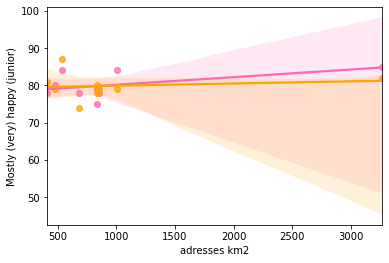

In [48]:
print('Linear regression for junior mood scores against adresses km2')
# plot the linear regression for every junior specific indicator

# this indicator does what is expected after reading the p-value, it shows some slight linear correlation
sns.regplot(x="adresses km2", 
            y="Moderately increased or increased risk of psychosocial problems (junior)", 
            data=mapping_dataframe,
            color='hotpink');

# this indicator does not show any significant correlation, as was expected.
sns.regplot(x="adresses km2", 
            y="Mostly (very) happy (junior)", 
            data=mapping_dataframe,
            color='orange');

Linear regression for adult mood scores against adresses km2


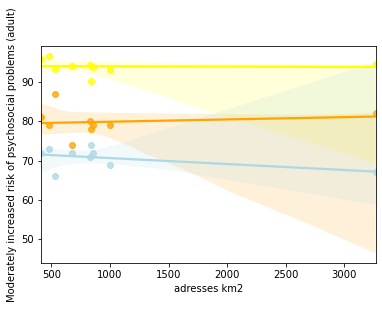

In [49]:
print('Linear regression for adult mood scores against adresses km2')
# plot the linear regression for every adult specific indicator

# this indicator does not show any correlation; which was expected
sns.regplot(x="adresses km2", 
            y="Increased risk of psychosocial problems (adult)", 
            data=mapping_dataframe,
            color='yellow');

# this indicator does not show any correlation; which was expected
sns.regplot(x="adresses km2", 
            y="Mostly (very) happy (adult)", 
            data=mapping_dataframe,
            color='orange');

# this indicator does not show any correlation; which was not expected after reading the p-value but was expected
# from reading the other plots.
sns.regplot(x="adresses km2", 
            y="Moderately increased risk of psychosocial problems (adult)", 
            data=mapping_dataframe,
            color='lightblue');

### Conclusion

This analysis was done to get an answer on 'Does the urbanity of your hometown have an influence on your mental health?'. This document provides several steps in the data analysis process including data preparing, data handling, visualising and provinding statistical tests to back up all the visualisations. The final conclusion are two partly conclusions; two for different indicators.

#### Yes, there are correlations

For two indicators, it does show that urbanity has an influence on people mental health. <br/><br/> <i> 'Moderately increased risk of psychosocial problems'</i>  for adults show to have a lower score in the urban townships. It also shows that for this indicator, there are some correlations to be found (with an r-score of 0.487148 and a p-value of 0.002074). <br/><br/> <i> 'Moderately increased or increased risk of psychosocial problems'</i>  for juniors show to have a higher score in the urban townships. It also shows that for this indicator, there are some correlations to be found (with an r-score of o.520563 and a p-value of 0.00012).  <br/><br/> This does show the idea that is more common these days; younger people struggle with depression, mainly in larger cities due to making them feel lonely. Perhaps elderly have more confidence to ensure they feel even more comfortable in larger cities, but that would have to be analysed in a different study :)

#### No, there are no correlations

For three (three out of five) indicators it does not show any significant correlation for urbanity and mental health. Neither the plots nor the statistical analysis show that there is any correlation between <i> 'Increased risk of psychosocial problems' </i> for adults, <i>hapiness</i> for adults and juniors and urbanity.


### unit test

In [50]:
import doctest
# unit tests are done ensure the proper working of functions. I have decided to put a unit test on two dataframes
# to get the understanding of how this idea works. The larger dataframes were also in the unit tests; but 
# ended up not working due to backspaces issues.
doctest.testmod(verbose=True)

Trying:
    latlon_df_part_2()
Expecting:
               township     latitude         longitude  adresses km2 urbanity
    0         Groningen   53.2193835         6.5665018          3267    urban
    1      Het Hogeland  53.41292275  6.50572993763598           410    rural
    2          Delfzijl   53.3310272         6.9244598           678    rural
    3  Midden-Groningen   53.1846736  6.77957351472961           853    rural
    4           Oldambt   53.2036908           7.05297           830    rural
    5            Pekela   53.0852407         6.9778815           531    rural
    6       Stadskanaal   52.9919853         6.9462217           836    rural
    7           Veendam   53.1062782         6.8750998          1002    urban
    8    Westerkwartier  53.21425645  6.34598133794401           475    rural
ok
Trying:
    regional_data()
Expecting:
               township  adresses km2 urbanity
    0         Groningen          3267    urban
    1      Het Hogeland           410    r

<ipython-input-6-d866dad4fc6a>:48: FutureWarning: The default value of regex will change from True to False in a future version.
  km['adresses km2'] = km['adresses km2'].str.replace('\.','').astype(int)


TestResults(failed=0, attempted=2)